# Heuristiques pour la coloration de graphe

#### 1. Membres :
  - Hamadene Kamelia
  - Laouzai Lina
  - Amoura Yousra
  - Ouadi Amina Tinhinene
  - Ouikene Youcef
  - Aoulmi Lina

#### 2. Introduction :
La coloration de graphe est un problème classique d'optimisation combinatoire qui consiste à attribuer des couleurs aux sommets d'un graphe de telle sorte que deux sommets adjacents
ne partagent jamais la même couleur, tout en minimisant le nombre de couleurs utilisées.

Le nombre minimum de couleurs nécessaires pour colorer un graphe est appelé nombre chromatique du graphe, noté χ(G).

Comme ce problème est NP-difficile, on utilise des heuristiques pour trouver des solutions approximatives en temps raisonnable. Dans ce notebook, nous allons étudier deux heuristiques:
1. La méthode de Welsh-Powell
2. La méthode DSATUR (Degree of SATURation)
3. La méthode des chaînes de Kempe (amélioration itérative)

Nous allons comparer ces méthodes sur différents benchmarks et analyser leurs performances par rapport à l'algorithme exact Branch & Bound (B&B).


In [ ]:
## Importation des bibliothéques
import networkx as nx
import matplotlib.pyplot as plt
import time
import numpy as np
import random
from collections import defaultdict
from google.colab import files

In [ ]:
## Lecture des graphes au format DIMACS .col

def lire_fichier_col(filename):
    """
    Lit un fichier au format DIMACS .col et retourne un graphe NetworkX
    """
    G = nx.Graph()

    with open(filename, 'r') as file:
        for line in file:
            if line.startswith('e'):  # Ligne décrivant une arête
                _, u, v = line.split()
                G.add_edge(int(u), int(v))
            elif line.startswith('n'):  # Ligne décrivant un nœud (si présent)
                parts = line.split()
                if len(parts) >= 3:  # Format "n node_id node_weight"
                    _, node, weight = parts
                    G.add_node(int(node), weight=int(weight))

    # Ajouter des nœuds isolés si nécessaire
    max_node = max(G.nodes()) if G.nodes() else 0
    for i in range(1, max_node + 1):
        if i not in G:
            G.add_node(i)

    return G

In [ ]:
# Chargement du graphe à partir d'un fichier benchmark
def charger_graphe_benchmark():
    print("Veuillez télécharger un fichier benchmark au format .col")
    uploaded = files.upload()

    if not uploaded:
        print("Aucun fichier n'a été téléchargé. Utilisation d'un graphe aléatoire de test.")
        return nx.gnp_random_graph(10, 0.5)

    filename = next(iter(uploaded))
    G = lire_fichier_col(filename)

    print(f"Graphe chargé avec succès : {G.number_of_nodes()} sommets et {G.number_of_edges()} arêtes")
    return G, filename

In [ ]:
## Visualisation de graphes

def visualiser_graphe_colore(G, coloration):
    """
    Visualise un graphe avec une coloration donnée
    """
    # Assigner des couleurs prédéfinies pour la visualisation
    colors = plt.cm.rainbow(np.linspace(0, 1, max(coloration.values()) + 1))

    # Créer une liste de couleurs pour chaque nœud
    node_colors = [colors[coloration[node]] for node in G.nodes()]

    # Positions des nœuds
    pos = nx.spring_layout(G, seed=42)

    # Dessiner le graphe
    plt.figure(figsize=(10, 7))
    nx.draw(G, pos, node_color=node_colors, with_labels=True, node_size=500, font_weight='bold')
    plt.title(f"Coloration avec {max(coloration.values()) + 1} couleurs")
    plt.show()

### **Méthode de Welsh-Powell**



## Principe
La méthode de Welsh-Powell est une heuristique gloutonne qui suit les étapes suivantes:
1. Trier les sommets par ordre décroissant de degré
2. Parcourir les sommets dans cet ordre
3. Pour chaque sommet, attribuer la plus petite couleur qui n'est pas déjà utilisée par un sommet adjacent

Cette méthode est simple à implémenter mais ne garantit pas une solution optimale.


In [ ]:
def welsh_powell(G):
    """
    Implémentation de l'algorithme de Welsh-Powell pour la coloration de graphe

    Paramètres:
    G: un graphe NetworkX

    Retourne:
    coloration: dictionnaire avec les sommets comme clés et les couleurs comme valeurs
    temps_execution: temps d'exécution en secondes
    """
    debut = time.time()

    # Trier les sommets par ordre décroissant de degré
    sommets_tries = sorted(G.nodes(), key=lambda x: G.degree(x), reverse=True)

    # Initialiser la coloration (les couleurs commencent à 0)
    coloration = {}

    # Pour chaque sommet dans l'ordre
    for sommet in sommets_tries:
        # Récupérer les couleurs utilisées par les voisins
        couleurs_voisins = {coloration[voisin] for voisin in G.neighbors(sommet) if voisin in coloration}

        # Trouver la plus petite couleur non utilisée par les voisins
        couleur = 0
        while couleur in couleurs_voisins:
            couleur += 1

        # Attribuer cette couleur au sommet
        coloration[sommet] = couleur

    fin = time.time()
    temps_execution = fin - debut

    return coloration, temps_execution

### **Méthode DSATUR (Degree of SATURation)**

## Principe
DSATUR est une amélioration par rapport à Welsh-Powell qui tient compte du dynamisme de la saturation:
1. La saturation d'un sommet est le nombre de couleurs différentes utilisées par ses voisins
2. À chaque étape, on choisit le sommet non coloré avec la plus grande saturation
3. En cas d'égalité, on choisit le sommet de plus haut degré
4. On lui attribue la plus petite couleur disponible

In [ ]:
def dsatur(G):
    """
    Implémentation de l'algorithme DSATUR pour la coloration de graphe

    Paramètres:
    G: un graphe NetworkX

    Retourne:
    coloration: dictionnaire avec les sommets comme clés et les couleurs comme valeurs
    temps_execution: temps d'exécution en secondes
    """
    debut = time.time()

    # Initialiser la coloration
    coloration = {}

    # Initialiser le degré de saturation (nombre de couleurs différentes dans le voisinage)
    saturation = {sommet: 0 for sommet in G.nodes()}

    # Tant qu'il reste des sommets à colorer
    while len(coloration) < len(G.nodes()):
        # Sélectionner le sommet non coloré avec la plus grande saturation
        sommets_non_colores = [s for s in G.nodes() if s not in coloration]

        # Trouver le sommet avec la plus grande saturation
        max_saturation = -1
        meilleur_sommet = None

        for sommet in sommets_non_colores:
            if saturation[sommet] > max_saturation:
                max_saturation = saturation[sommet]
                meilleur_sommet = sommet
            elif saturation[sommet] == max_saturation:
                # En cas d'égalité, choisir le sommet avec le plus grand degré
                if G.degree(sommet) > G.degree(meilleur_sommet):
                    meilleur_sommet = sommet

        # Trouver la plus petite couleur disponible pour ce sommet
        couleurs_voisins = {coloration[voisin] for voisin in G.neighbors(meilleur_sommet) if voisin in coloration}
        couleur = 0
        while couleur in couleurs_voisins:
            couleur += 1

        # Attribuer cette couleur au sommet
        coloration[meilleur_sommet] = couleur

        # Mettre à jour la saturation des voisins non colorés
        for voisin in G.neighbors(meilleur_sommet):
            if voisin not in coloration:
                # Compter les couleurs distinctes dans le voisinage
                couleurs_voisins_du_voisin = {coloration[v] for v in G.neighbors(voisin) if v in coloration}
                saturation[voisin] = len(couleurs_voisins_du_voisin)

    fin = time.time()
    temps_execution = fin - debut

    return coloration, temps_execution

# Méthode des chaînes de Kempe

### Principe

La méthode des chaînes de Kempe introduite par Alfred Bray Kempe en 1879 dans le contexte du théorème des quatre couleurs, est une technique d'amélioration itérative pour la coloration de graphe.

Une chaîne de Kempe est définie comme suit :
- Soit G un graphe et C une coloration valide de G
- Pour deux couleurs distinctes a et b, une chaîne de Kempe (a,b) est un sous-graphe connexe maximal de G qui ne contient que des sommets colorés soit avec a, soit avec b

L'opération fondamentale des chaînes de Kempe consiste à échanger les couleurs a et b au sein d'une chaîne de Kempe. Cette opération préserve la validité de la coloration car :
1. Deux sommets adjacents dans la chaîne ont nécessairement des couleurs différentes (l'un a, l'autre b)
2. Après l'échange, ils auront toujours des couleurs différentes (l'un b, l'autre a)
3. Les sommets en dehors de la chaîne ne sont pas affectés
4. Les sommets de la chaîne ne peuvent pas être adjacents à d'autres sommets de la chaîne de même couleur (par maximalité de la chaîne)

### Paramètres d'entrée

Notre implémentation de la méthode des chaînes de Kempe prend les paramètres suivants :

1. **G** (NetworkX Graph) : Le graphe sur lequel appliquer la coloration
2. **coloration_initiale** (dictionnaire, optionnel) :  Une coloration valide de départ, générée par une méthode de coloration aléatoire si non fournie.
3. **iterations** (entier) : Le nombre d'itérations à effectuer pour la recherche d'amélioration
4. **stabilite_max** (entier) : Nombre d'itérations sans amélioration avant arrêt de l'algorithme

### Nombre d'itérations et critère d'arrêt

Deux paramètres définissent l'exécution de notre algorithme :

- **Nombre maximal d'itérations** : Dépend du degré moyen du graphe. Quand le degré augmente, le nombre d'itérations augmente avec. Notre implémentation utilise par défaut 5000 itérations.
- **Critère de stabilité** : Si le nombre chromatique (nombre de couleurs) reste stable pendant un certain nombre d'itérations consécutives (stabilite_max), l'algorithme s'arrête, même si le nombre maximal d'itérations n'est pas atteint.

### Approche multi-start
Notre implémentation utilise une approche multi-start pour améliorer la qualité des solutions :

- Plusieurs colorations initiales aléatoires sont générées (par défaut 10 tests)
- Pour chaque coloration initiale, l'algorithme des chaînes de Kempe est exécuté
- La meilleure coloration trouvée parmi tous les tests est retenue




### Processus d'exécution

À chaque itération de l'algorithme des chaînes de Kempe :

1. **Sélection aléatoire** : Un sommet est choisi aléatoirement dans le graphe
2. **Sélection de couleurs** : La couleur actuelle du sommet et une autre couleur sont choisies
3. **Construction de la chaîne** : La chaîne de Kempe contenant le sommet sélectionné est identifiée par un parcours en largeur
4. **Échange de couleurs** : Les couleurs sont échangées au sein de la chaîne
5. **Évaluation** : Si la nouvelle coloration utilise moins de couleurs, elle devient la meilleure coloration connue
6. **Vérification du critère d'arrêt** : Si le nombre de couleurs est stable depuis stabilite_max itérations, l'algorithme s'arrête

Cette implémentation permet de trouver efficacement de bonnes solutions au problème de coloration de graphe tout en évitant des calculs inutiles lorsque la solution ne s'améliore plus.

In [ ]:
def multi_start_kempe_chains(G, nb_starts=10, iterations_par_start=5000, stabilite_max=1000):
    """
    Implémentation de l'approche multi-start pour les chaînes de Kempe
    avec critère d'arrêt sur la stabilité du nombre chromatique

    Paramètres:
    G: un graphe NetworkX
    nb_starts: nombre d'exécutions avec différentes colorations initiales
    iterations_par_start: nombre maximal d'itérations à effectuer pour chaque départ
    stabilite_max: nombre d'itérations sans amélioration avant arrêt

    Retourne:
    meilleure_coloration: dictionnaire avec les sommets comme clés et les couleurs comme valeurs
    temps_execution: temps d'exécution en secondes
    """
    debut = time.time()

    meilleure_coloration = None
    meilleur_nb_couleurs = float('inf')

    # Pour chaque départ
    for start in range(nb_starts):
        coloration_initiale = random_coloring(G)

        # Exécuter l'algorithme des chaînes de Kempe avec le critère de stabilité
        coloration, _ = kempe_chains(G, coloration_initiale, iterations_par_start, stabilite_max)

        # Calculer le nombre de couleurs
        nb_couleurs = max(coloration.values()) + 1

        # Si c'est la meilleure coloration jusqu'à présent
        if nb_couleurs < meilleur_nb_couleurs:
            meilleure_coloration = coloration
            meilleur_nb_couleurs = nb_couleurs

    fin = time.time()
    temps_execution = fin - debut

    meilleure_coloration = reduire_couleurs(G, meilleure_coloration)


    return meilleure_coloration, temps_execution


def random_coloring(G):
    """
    Coloration aléatoire du graphe

    Paramètres:
    G: un graphe NetworkX

    Retourne:
    coloration: dictionnaire avec les sommets comme clés et les couleurs comme valeurs
    """
    coloration = {}

    # Pour chaque sommet
    for sommet in G.nodes():
        # Couleurs utilisées par les voisins
        couleurs_voisins = {coloration[v] for v in G.neighbors(sommet) if v in coloration}

        # Couleurs disponibles
        couleurs_disponibles = [c for c in range(len(G.nodes())) if c not in couleurs_voisins]

        # Choisir aléatoirement une couleur disponible
        coloration[sommet] = random.choice(couleurs_disponibles)

    return coloration

In [ ]:
def kempe_chains(G, coloration_initiale=None, iterations=1000, stabilite_max=1000):
    """
    Implémentation de l'heuristique des chaînes de Kempe pour la coloration de graphe
    avec critère d'arrêt sur la stabilité du nombre chromatique

    Paramètres:
    G: un graphe NetworkX
    coloration_initiale: dictionnaire de coloration initiale (si None, on utilise DSATUR)
    iterations: nombre maximal d'itérations à effectuer
    stabilite_max: nombre d'itérations sans amélioration avant arrêt

    Retourne:
    meilleure_coloration: dictionnaire avec les sommets comme clés et les couleurs comme valeurs
    temps_execution: temps d'exécution en secondes
    """
    debut = time.time()

    # Si aucune coloration initiale n'est fournie, utiliser DSATUR
    if coloration_initiale is None:
        coloration_initiale, _ = dsatur(G)

    # Nombre de couleurs de la coloration initiale
    nb_couleurs_initial = max(coloration_initiale.values()) + 1

    # Copier la coloration initiale
    meilleure_coloration = coloration_initiale.copy()
    meilleur_nb_couleurs = nb_couleurs_initial

    # Compteur pour la stabilité
    iterations_sans_amelioration = 0

    # Pour chaque itération
    for iter in range(iterations):
        # Copier la meilleure coloration actuelle
        coloration_courante = meilleure_coloration.copy()

        # Sélectionner aléatoirement un sommet
        sommet = random.choice(list(G.nodes()))

        # Sélectionner aléatoirement deux couleurs différentes
        couleur_actuelle = coloration_courante[sommet]
        autres_couleurs = list(set(range(meilleur_nb_couleurs)) - {couleur_actuelle})

        if not autres_couleurs:  # Si une seule couleur est utilisée
            continue

        couleur_cible = random.choice(autres_couleurs)

        # Construire la chaîne de Kempe
        chaine_kempe = construire_chaine_kempe(G, coloration_courante, sommet, couleur_actuelle, couleur_cible)

        # Échanger les couleurs dans la chaîne
        for s in chaine_kempe:
            if coloration_courante[s] == couleur_actuelle:
                coloration_courante[s] = couleur_cible
            else:
                coloration_courante[s] = couleur_actuelle

        # Vérifier si la nouvelle coloration est valide
        if est_coloration_valide(G, coloration_courante):
            # Calculer le nombre de couleurs utilisées
            nb_couleurs_courantes = max(coloration_courante.values()) + 1
            coloration_courante = reduire_couleurs(G, coloration_courante)


            # Si on améliore le nombre de couleurs, mettre à jour la meilleure coloration
            if nb_couleurs_courantes < meilleur_nb_couleurs:
                meilleure_coloration = coloration_courante.copy()
                meilleur_nb_couleurs = nb_couleurs_courantes
                iterations_sans_amelioration = 0  # Réinitialiser le compteur
            else:
                iterations_sans_amelioration += 1  # Incrémenter le compteur

            # Vérifier le critère d'arrêt basé sur la stabilité
            if iterations_sans_amelioration >= stabilite_max:
                print(f"Arrêt après {iter+1} itérations: nombre chromatique stable depuis {stabilite_max} itérations")
                break
        else:
            iterations_sans_amelioration += 1  # Incrémenter aussi pour les colorations non valides

            # Vérifier le critère d'arrêt basé sur la stabilité
            if iterations_sans_amelioration >= stabilite_max:
                print(f"Arrêt après {iter+1} itérations: nombre chromatique stable depuis {stabilite_max} itérations")
                break

    fin = time.time()
    temps_execution = fin - debut

    return meilleure_coloration, temps_execution

def construire_chaine_kempe(G, coloration, sommet_depart, couleur1, couleur2):
    """
    Construit une chaîne de Kempe à partir d'un sommet de départ
    et des couleurs couleur1 et couleur2

    Paramètres:
    G: un graphe NetworkX
    coloration: dictionnaire de coloration
    sommet_depart: sommet de départ
    couleur1, couleur2: les deux couleurs de la chaîne

    Retourne:
    chaine: ensemble des sommets de la chaîne
    """
    # Initialiser la chaîne avec le sommet de départ
    chaine = {sommet_depart}
    file = [sommet_depart]

    # Parcours en largeur pour construire la chaîne
    while file:
        sommet = file.pop(0)

        # Pour chaque voisin du sommet
        for voisin in G.neighbors(sommet):
            # Si le voisin est coloré avec couleur1 ou couleur2 et n'est pas déjà dans la chaîne
            if coloration[voisin] in [couleur1, couleur2] and voisin not in chaine:
                chaine.add(voisin)
                file.append(voisin)

    return chaine


def est_coloration_valide(G, coloration):
    """
    Vérifie si une coloration est valide (aucune arête n'a ses deux extrémités de même couleur)

    Paramètres:
    G: un graphe NetworkX
    coloration: dictionnaire de coloration

    Retourne:
    bool: True si la coloration est valide, False sinon
    """
    for u, v in G.edges():
        if coloration[u] == coloration[v]:
            return False
    return True

def reduire_couleurs(G, coloration):
    """
    Tente de réduire le nombre de couleurs utilisées dans une coloration

    Paramètres:
    G: un graphe NetworkX
    coloration: dictionnaire de coloration

    Retourne:
    coloration_optimisee: dictionnaire avec les sommets comme clés et les couleurs comme valeurs
    """
    # Copier la coloration
    coloration_optimisee = coloration.copy()

    # Nombre de couleurs utilisées
    nb_couleurs = max(coloration_optimisee.values()) + 1

    # Pour chaque couleur, essayer de réduire
    for couleur in range(nb_couleurs - 1, 0, -1):
        # Sommets de cette couleur
        sommets_couleur = [s for s in G.nodes() if coloration_optimisee[s] == couleur]

        # Pour chaque sommet de cette couleur
        for sommet in sommets_couleur:
            # Couleurs utilisées par les voisins
            couleurs_voisins = {coloration_optimisee[v] for v in G.neighbors(sommet)}

            # Trouver une couleur disponible inférieure
            for c in range(couleur):
                if c not in couleurs_voisins:
                    coloration_optimisee[sommet] = c
                    break

    return coloration_optimisee




# Application des méthodes sur un benchmark

Nous allons maintenant appliquer les deux méthodes sur un graphe chargé à partir d'un fichier benchmark au format .col.
"""

In [ ]:
def comparer_methodes_sur_benchmark(G, nom_benchmark, resultats_bb=None, iterations_par_start=8000,stabilite_max=1000):
    """
    Compare les différentes méthodes de coloration sur un benchmark donné

    Paramètres:
    G: un graphe NetworkX
    nom_benchmark: nom du benchmark pour l'affichage
    resultats_bb: résultats de Branch & Bound (dictionnaire avec 'couleurs' et 'temps')

    Retourne:
    resultats: dictionnaire des résultats (nombre de couleurs, temps d'exécution)
    """
    resultats = {}

    print(f"\n\n# Analyse du benchmark: {nom_benchmark}")
    print(f"Nombre de sommets: {G.number_of_nodes()}")
    print(f"Nombre d'arêtes: {G.number_of_edges()}")
    print(f"Degré moyen: {2 * G.number_of_edges() / G.number_of_nodes():.2f}")

    # Méthode Welsh-Powell
    print("\n## Méthode de Welsh-Powell")
    wp_coloration, wp_temps = welsh_powell(G)
    wp_nb_couleurs = max(wp_coloration.values()) + 1
    print(f"Nombre de couleurs utilisées: {wp_nb_couleurs}")
    print(f"Temps d'exécution: {wp_temps:.4f} secondes")

    # Visualiser si le graphe n'est pas trop grand
    if G.number_of_nodes() <= 100:
        visualiser_graphe_colore(G, wp_coloration)

    resultats['Welsh-Powell'] = {'couleurs': wp_nb_couleurs, 'temps': wp_temps}

    # Méthode DSATUR
    print("\n## Méthode DSATUR")
    ds_coloration, ds_temps = dsatur(G)
    ds_nb_couleurs = max(ds_coloration.values()) + 1
    print(f"Nombre de couleurs utilisées: {ds_nb_couleurs}")
    print(f"Temps d'exécution: {ds_temps:.4f} secondes")

    # Visualiser si le graphe n'est pas trop grand
    if G.number_of_nodes() <= 100:
        visualiser_graphe_colore(G, ds_coloration)

    resultats['DSATUR'] = {'couleurs': ds_nb_couleurs, 'temps': ds_temps}

    # Méthode Kempe Chains (avec approche multi-start)
    print("\n## Méthode des chaînes de Kempe (approche multi-start)")
    kc_coloration, kc_temps = multi_start_kempe_chains(G, nb_starts=30, iterations_par_start=8000,stabilite_max=1000)
    kc_nb_couleurs = max(kc_coloration.values()) + 1
    print(f"Nombre de couleurs utilisées: {kc_nb_couleurs}")
    print(f"Temps d'exécution: {kc_temps:.4f} secondes")

    # Visualiser si le graphe n'est pas trop grand
    if G.number_of_nodes() <= 100:
        visualiser_graphe_colore(G, kc_coloration)

    resultats['Kempe Chains'] = {'couleurs': kc_nb_couleurs, 'temps': kc_temps}

    # Inclure les résultats de Branch & Bound s'ils sont fournis
    if resultats_bb:
        print("\n## Méthode Branch & Bound")
        print(f"Nombre de couleurs utilisées: {resultats_bb['couleurs']}")
        print(f"Temps d'exécution: {resultats_bb['temps']:.4f} secondes")
        resultats['Branch & Bound'] = resultats_bb

    return resultats

def afficher_comparaison_resultats(resultats_benchmarks):
    """
    Affiche une comparaison des résultats pour différents benchmarks et méthodes

    Paramètres:
    resultats_benchmarks: dictionnaire des résultats par benchmark et par méthode
    """
    print("\n\n# Comparaison des résultats")

    # En-tête du tableau
    benchmarks = list(resultats_benchmarks.keys())

    # Trouver toutes les méthodes utilisées dans les différents benchmarks
    all_methodes = set()
    for benchmark in benchmarks:
        all_methodes.update(resultats_benchmarks[benchmark].keys())

    methodes = sorted(list(all_methodes))

    # Définir la largeur des colonnes
    benchmark_width = max(len("Benchmark"), max(len(b) for b in benchmarks))
    methode_width = max(len("Méthode"), max(len(m) for m in methodes))
    result_width = 20  # Largeur pour afficher "couleurs/temps"

    # Créer l'en-tête du tableau
    header = f"| {'Benchmark':<{benchmark_width}} | "
    for methode in methodes:
        header += f"{methode:<{methode_width}} | "
    print(header)

    # Ligne de séparation
    separator = "|" + "-" * (benchmark_width + 2) + "|"
    for _ in methodes:
        separator += "-" * (methode_width + 2) + "|"
    print(separator)

    # Lignes du tableau
    for benchmark in benchmarks:
        line = f"| {benchmark:<{benchmark_width}} | "
        for methode in methodes:
            if methode in resultats_benchmarks[benchmark]:
                res = resultats_benchmarks[benchmark][methode]
                line += f"{res['couleurs']:2d}/{res['temps']:6.2f}s | "
            else:
                line += " " * (methode_width - 3) + "N/A | "
        print(line)

    # Analyse des résultats
    print("\n## Analyse des résultats")
    print("- Les méthodes heuristiques sont généralement plus rapides mais peuvent donner des solutions moins optimales.")
    print("- Branch & Bound garantit l'optimalité mais peut être très lent sur de grands graphes.")
    print("- Les chaînes de Kempe avec approche multi-start offrent un bon compromis entre qualité et temps de calcul.")

    for benchmark in benchmarks:
        print(f"\n### {benchmark}")
        # Trouver la meilleure méthode (celle avec le moins de couleurs)
        methodes_dans_benchmark = resultats_benchmarks[benchmark].keys()
        if methodes_dans_benchmark:
            meilleure_methode = min(
                [(m, resultats_benchmarks[benchmark][m]) for m in methodes_dans_benchmark],
                key=lambda x: x[1]['couleurs']
            )
            print(f"Méthode la plus efficace: {meilleure_methode[0]} avec {meilleure_methode[1]['couleurs']} couleurs")

            # Si Branch & Bound est disponible, comparer avec
            if 'Branch & Bound' in resultats_benchmarks[benchmark]:
                bb_result = resultats_benchmarks[benchmark]['Branch & Bound']
                if meilleure_methode[0] != 'Branch & Bound':
                    ecart = meilleure_methode[1]['couleurs'] - bb_result['couleurs']
                    if ecart != 0:
                        print(f"Écart avec Branch & Bound: {ecart} couleur(s) ({ecart/bb_result['couleurs']*100:.1f}%)")
                    else:
                        print("La méthode heuristique a trouvé la solution optimale!")

### Test du 1er Benchmark :

# Chargement de benchmarks

Veuillez télécharger le premier benchmark
Veuillez télécharger un fichier benchmark au format .col


Saving dsjc125.1.col to dsjc125.1 (6).col
Graphe chargé avec succès : 28 sommets et 30 arêtes


# Analyse du benchmark: dsjc125.1 (6).col
Nombre de sommets: 28
Nombre d'arêtes: 30
Degré moyen: 2.14

## Méthode de Welsh-Powell
Nombre de couleurs utilisées: 3
Temps d'exécution: 0.0001 secondes


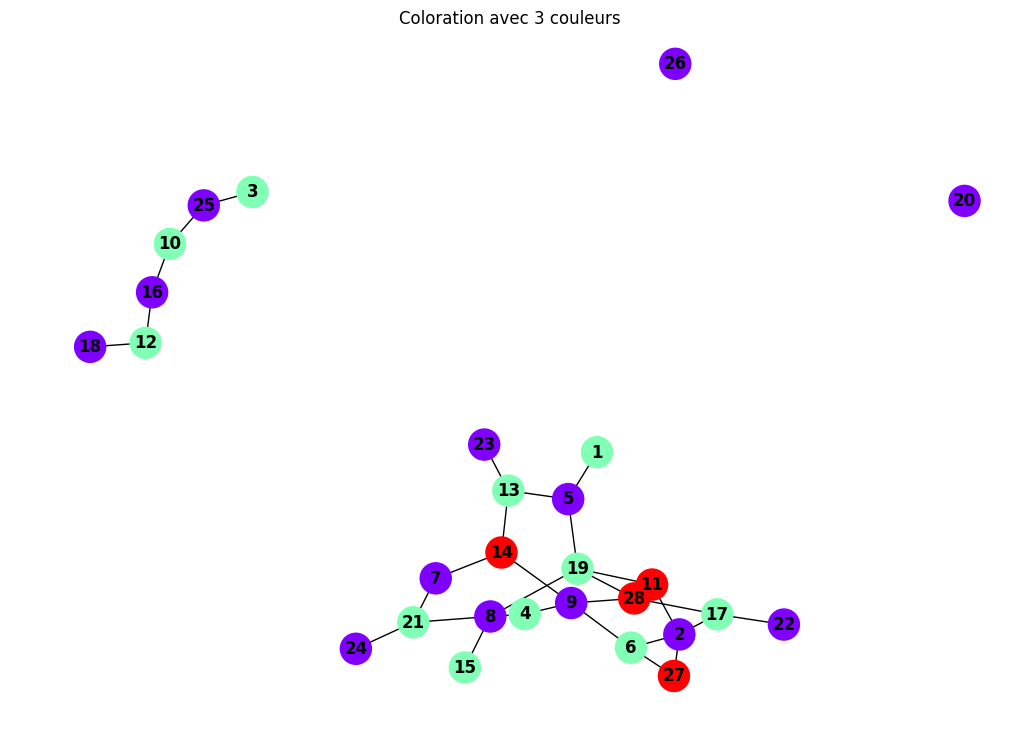


## Méthode DSATUR
Nombre de couleurs utilisées: 3
Temps d'exécution: 0.0005 secondes


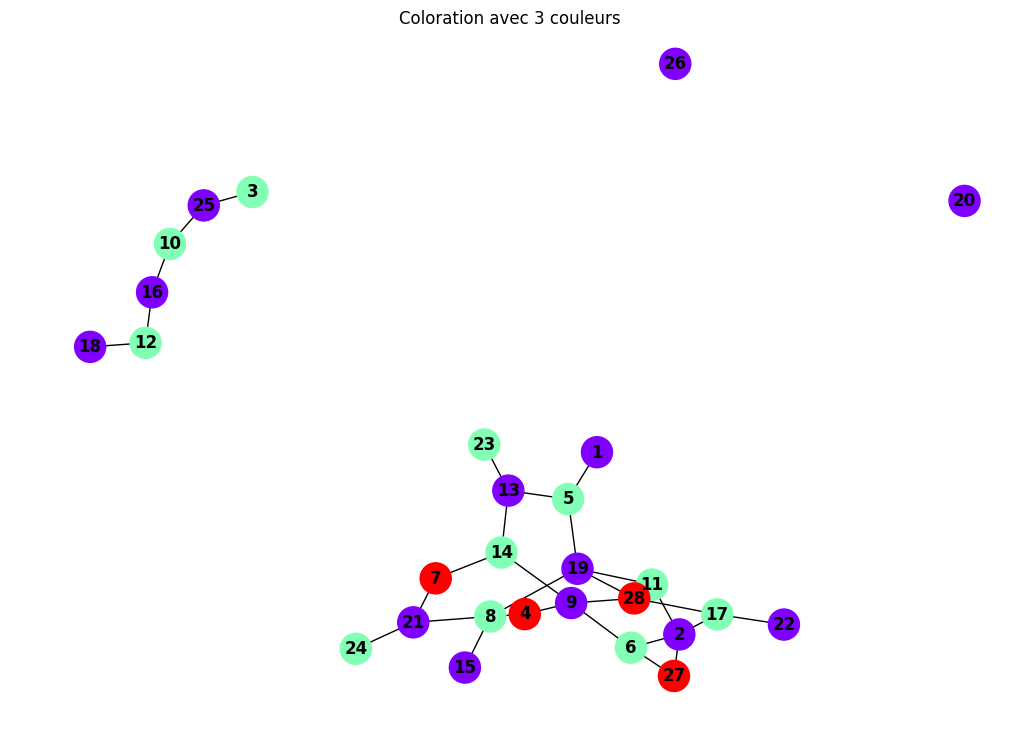


## Méthode des chaînes de Kempe (approche multi-start)
Arrêt après 1095 itérations: nombre chromatique stable depuis 1000 itérations
Arrêt après 1000 itérations: nombre chromatique stable depuis 1000 itérations
Arrêt après 1000 itérations: nombre chromatique stable depuis 1000 itérations
Arrêt après 1105 itérations: nombre chromatique stable depuis 1000 itérations
Arrêt après 1017 itérations: nombre chromatique stable depuis 1000 itérations
Arrêt après 1000 itérations: nombre chromatique stable depuis 1000 itérations
Arrêt après 1057 itérations: nombre chromatique stable depuis 1000 itérations
Arrêt après 1000 itérations: nombre chromatique stable depuis 1000 itérations
Arrêt après 1008 itérations: nombre chromatique stable depuis 1000 itérations
Arrêt après 1009 itérations: nombre chromatique stable depuis 1000 itérations
Arrêt après 1000 itérations: nombre chromatique stable depuis 1000 itérations
Arrêt après 1065 itérations: nombre chromatique stable depuis 1000 itérations
Arrêt ap

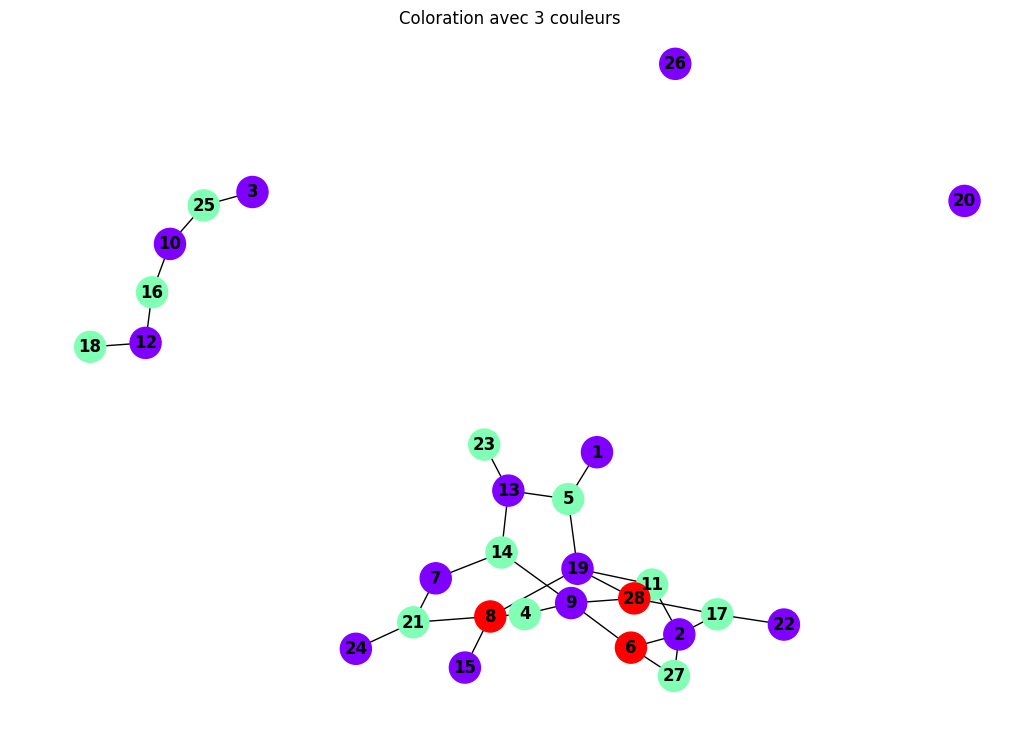


## Méthode Branch & Bound
Nombre de couleurs utilisées: 3
Temps d'exécution: 0.0020 secondes


In [ ]:
# Charger les deux benchmarks
print("# Chargement de benchmarks")
print("\nVeuillez télécharger le premier benchmark")
try:
    G1, filename1 = charger_graphe_benchmark()
    resultats_bb1 = {'couleurs': 3, 'temps': 0.002}
    resultats_benchmark1 = comparer_methodes_sur_benchmark(G1, filename1, resultats_bb1, iterations_par_start=1000, stabilite_max=100)

except Exception as e:
    print(f"Une erreur s'est produite: {e}")
    print("Utilisation de graphes de test...")



### Test du 2éme benchmark

# Chargement de benchmark

Veuillez télécharger le 2éme benchmark
Veuillez télécharger un fichier benchmark au format .col


Saving dsjc70.col to dsjc70 (7).col
Graphe chargé avec succès : 70 sommets et 234 arêtes


# Analyse du benchmark: dsjc70 (7).col
Nombre de sommets: 70
Nombre d'arêtes: 234
Degré moyen: 6.69

## Méthode de Welsh-Powell
Nombre de couleurs utilisées: 5
Temps d'exécution: 0.0001 secondes


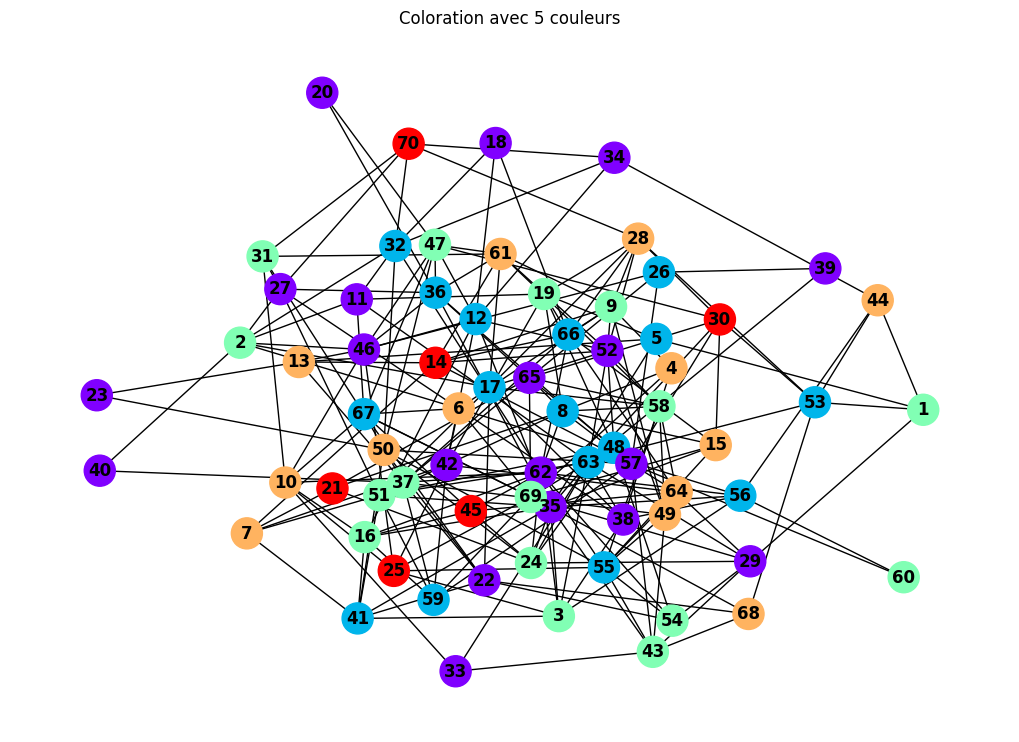


## Méthode DSATUR
Nombre de couleurs utilisées: 5
Temps d'exécution: 0.0015 secondes


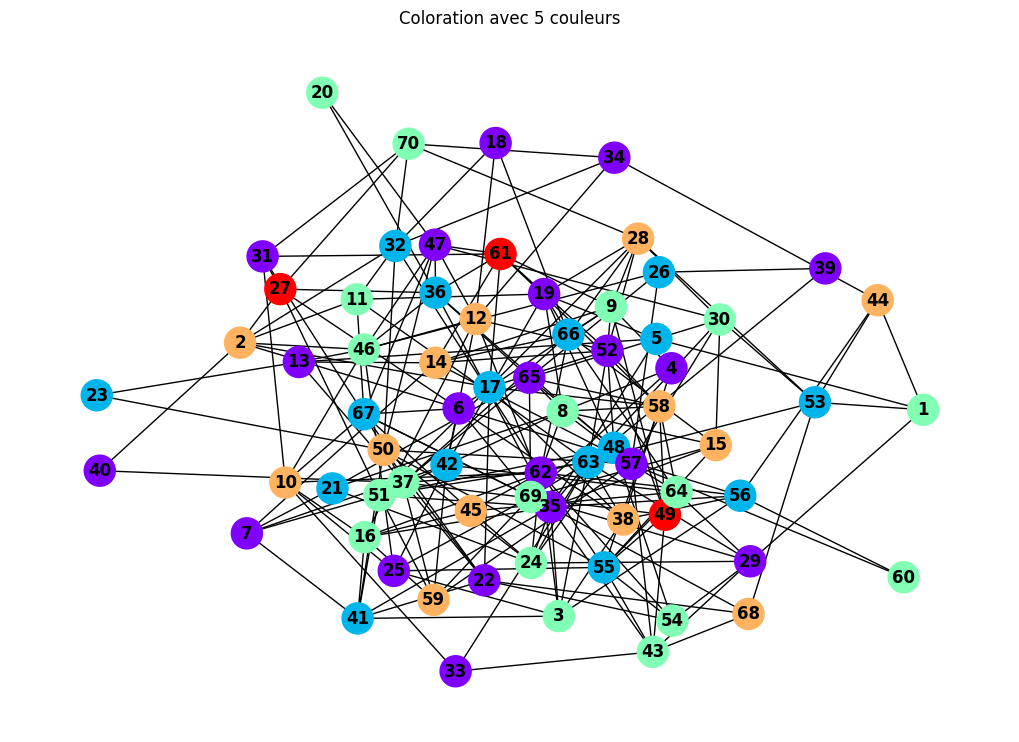


## Méthode des chaînes de Kempe (approche multi-start)
Arrêt après 1047 itérations: nombre chromatique stable depuis 1000 itérations
Arrêt après 1032 itérations: nombre chromatique stable depuis 1000 itérations
Arrêt après 1050 itérations: nombre chromatique stable depuis 1000 itérations
Arrêt après 1099 itérations: nombre chromatique stable depuis 1000 itérations
Arrêt après 1184 itérations: nombre chromatique stable depuis 1000 itérations
Arrêt après 1097 itérations: nombre chromatique stable depuis 1000 itérations
Arrêt après 1015 itérations: nombre chromatique stable depuis 1000 itérations
Arrêt après 1000 itérations: nombre chromatique stable depuis 1000 itérations
Arrêt après 1000 itérations: nombre chromatique stable depuis 1000 itérations
Arrêt après 1000 itérations: nombre chromatique stable depuis 1000 itérations
Arrêt après 1152 itérations: nombre chromatique stable depuis 1000 itérations
Arrêt après 1039 itérations: nombre chromatique stable depuis 1000 itérations
Arrêt ap

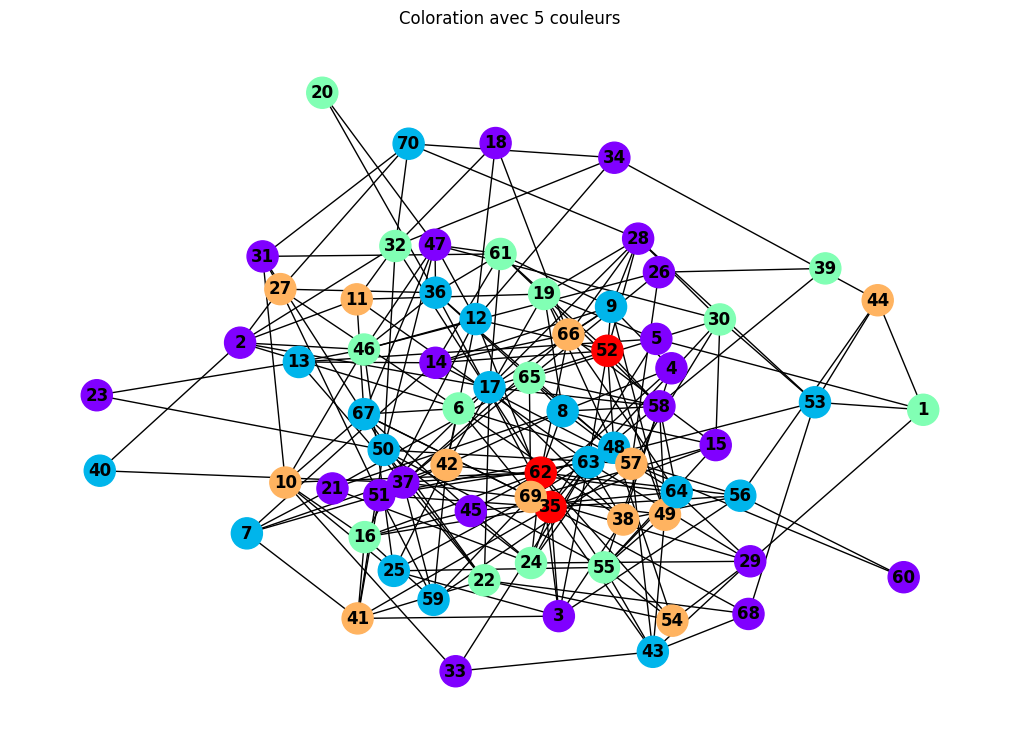


## Méthode Branch & Bound
Nombre de couleurs utilisées: 4
Temps d'exécution: 213.6800 secondes


In [ ]:
# Charger les deux benchmarks
print("# Chargement de benchmark")
print("\nVeuillez télécharger le 2éme benchmark")
try:
    G2, filename2 = charger_graphe_benchmark()
    resultats_bb2 = {'couleurs': 4, 'temps': 213.68}
    resultats_benchmark2 = comparer_methodes_sur_benchmark(G2, filename2, resultats_bb2, iterations_par_start=5000, stabilite_max=500)

    # Combiner les résultats des deux benchmarks
    tous_resultats = {
        filename1: resultats_benchmark1,
        filename2: resultats_benchmark2
    }


except Exception as e:
    print(f"Une erreur s'est produite: {e}")
    print("Utilisation de graphes de test...")



# Résultats et Comparaison

## Contexte de l'étude

Dans cette étude, nous avons testé **2 benchmarks** en utilisant les **3 méthodes** que nous avons implémentées :  
1. **DSatur**  
2. **Welsh-Powell**  
3. **Kempe Chains**  

Les benchmarks utilisés sont :  
- **Benchmark 1** : Un graphe de **30 sommets**.  
- **Benchmark 2** : Un graphe de **70 sommets**.  

Pour évaluer la performance de ces méthodes, nous les avons comparées à la méthode **Branch & Bound (B&B)**, qui garantit une solution exacte.  

---

## Résultats de Branch & Bound (B&B)

Voici les résultats obtenus avec la méthode **Branch & Bound** pour les deux benchmarks :  
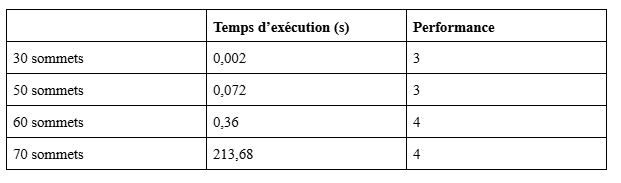
---

## Comparaison des méthodes

### Benchmark 1 (30 sommets)

**Tableau comparatif** :  
*(Ajouter les valeurs ici)*  

| Méthode          | Nombre de couleurs  |  Temps d'exécution |  
|------------------|---------------------|--------------------|  
| DSatur           |         3           |   0,0001           |  
| Welsh-Powell     |         3           |   0,0005           |  
| Kempe Chains     |         3           |   1.8969           |  
| Branch & Bound   |         3           |   0,0020           |  

**Conclusion** :  
- **DSatur** et **Welsh-Powell** sont très performants et rapides pour ce benchmark.  
- L'algorithme d'amélioration (**Kempe Chains**) n'est pas très adapté pour les petits graphes, car il nécessite plusieurs itérations. Avec l'approche multi-start, il prend plus de temps, ce qui le rend moins performant (temps d'exécution plus long ou proche de celui de B&B).  
- **Branch & Bound** fournit une solution exacte, mais son temps d'exécution est plus élevé pour ce petit graphe.  

---

### Benchmark 2 (70 sommets)

**Tableau comparatif** :  
*(Ajouter les valeurs ici)*  

| Méthode          | Nombre de couleurs  |  Temps d'exécution |  
|------------------|---------------------|--------------------|  
| DSatur           |     5               |      0.0001        |  
| Welsh-Powell     |     5               |      0.0015        |  
| Kempe Chains     |     5               |      10.3852       |  
| Branch & Bound   |     4               |      213,680       |  

**Conclusion** :  
- **DSatur** et **Welsh-Powell** restent très performants et rapides.  
- **Branch & Bound** donne une solution exacte (4 couleurs), tandis que les autres méthodes donnent des résultats légèrement moins optimaux (5 couleurs).  
- Les méthodes heuristiques (**DSatur** et **Welsh-Powell**) sont très rapides, même pour des graphes plus grands.  
- **Branch & Bound** prend un temps d'exécution beaucoup plus long, car sa complexité augmente rapidement avec la taille du graphe (de l'ordre de \(n^k\)).  
- L'algorithme d'amélioration (**Kempe Chains**) voit son nombre d'itérations augmenter avec la taille du graphe, mais dans ce test, il reste plus rapide que **Branch & Bound**.  

---


# Conclusion générale

- Le nombre chromatique exact d'un graphe est souvent inconnu pour des graphes complexes, ce qui rend les méthodes heuristiques indispensables pour obtenir des solutions approchées en un temps raisonnable.  
- Parmi les méthodes testées :  
  - **DSatur** et **Welsh-Powell** sont des heuristiques rapides et efficaces, adaptées à la plupart des cas. **DSatur** produit généralement des colorations avec moins de couleurs que **Welsh-Powell**.  
  - **Branch & Bound** garantit une solution exacte, mais son temps d'exécution devient prohibitif pour des graphes de grande taille en raison de sa complexité exponentielle.  
  - **Kempe Chains** est moins adapté pour les petits graphes, mais peut être utile pour les graphes plus grands, où il reste plus rapide que **Branch & Bound**.  
- La structure du graphe influence fortement la performance des algorithmes, tant en termes de qualité des solutions que de temps d'exécution.  

Dans ce notebook, nous avons implémenté et comparé plusieurs méthodes de coloration de graphe, mettant en évidence :  
- L'efficacité des heuristiques (**DSatur** et **Welsh-Powell**) pour fournir des solutions rapides et de bonne qualité.  
- L'importance de choisir la méthode en fonction de la taille et de la structure du graphe.  
- Le compromis entre optimalité et temps d'exécution, illustré par la comparaison entre **Branch & Bound** et les méthodes heuristiques.  
